# DrivenData Tanzania Challenge

## Index

0. Loading data  
1. Exploratory Data Analysis and Understanding  
    1.1 Data Distribution and Statistics  
    1.2 Advanced Data Exploration  
    1.3 Meaningless Features   
    1.4 Data Correctness  
    1.5 Missing values 
2. Feature Engineering  
3. Feature Selection  
    3.1 Information gain  
    3.2 LogisticRegression L1 selection 
4. Modeling and Evaluation  
    4.1 Random Forest  
        4.1.1 Random Forest without PCA    
        4.1.2 Random Forest with PCA  
    4.2 XGBoost   
    4.3 LDA  
    4.4 LightGBM  
    4.5 Voting Classsifier  
5. Final Remarks  
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA

from category_encoders import CountEncoder # requires separate installation
from custom_transformers import OurSimpleImputer, OurAdvancedImputer, DataCorrection, DropColumns
from custom_transformers import GeoClustering, Distance, Interactions, OtherFeatures

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

/Users/ekaterina/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# 0. Loading Data

In [2]:
original_train_values = pd.read_csv('data/train.csv')
original_train_labels = pd.read_csv('data/train_labels.csv')
test = pd.read_csv('data/test.csv')
original_train = pd.merge(original_train_values, original_train_labels, on='id')
original_train.date_recorded = pd.to_datetime(original_train.date_recorded)

In [3]:
original_train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [3]:
train = original_train.copy()

# 1. Exploratory Data Analysis and Understanding

## 1.1 Data Distribution and Statistics

To begin, we will look at the distribution of the target variable in the train dataset.

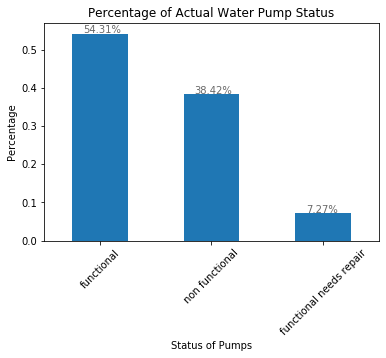

In [8]:
# Bar Plot

# Plot the percentages of actual water pump status'
ax = train['status_group'].value_counts(normalize=True).plot(kind='bar')

# Set title and labels
ax.set_title('Percentage of Actual Water Pump Status')
ax.set_xlabel('Status of Pumps')
ax.set_ylabel('Percentage')
plt.xticks(rotation=45)

# Annotate
totals=[]
for i in ax.patches:
    totals.append(i.get_height())
    
total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()+.001,
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=10, color='dimgrey')

As can be seen from the bar plot above, there are much more pumps that are functional and non-functional in our dataset and only a mere 7.27% of our dataset contains pumps that are functional but need repair. This may represent a class-imbalance issue later on when predicting the classes for the test dataset.

Placeholder Column by column stats and distribution

    Correlation matrix:

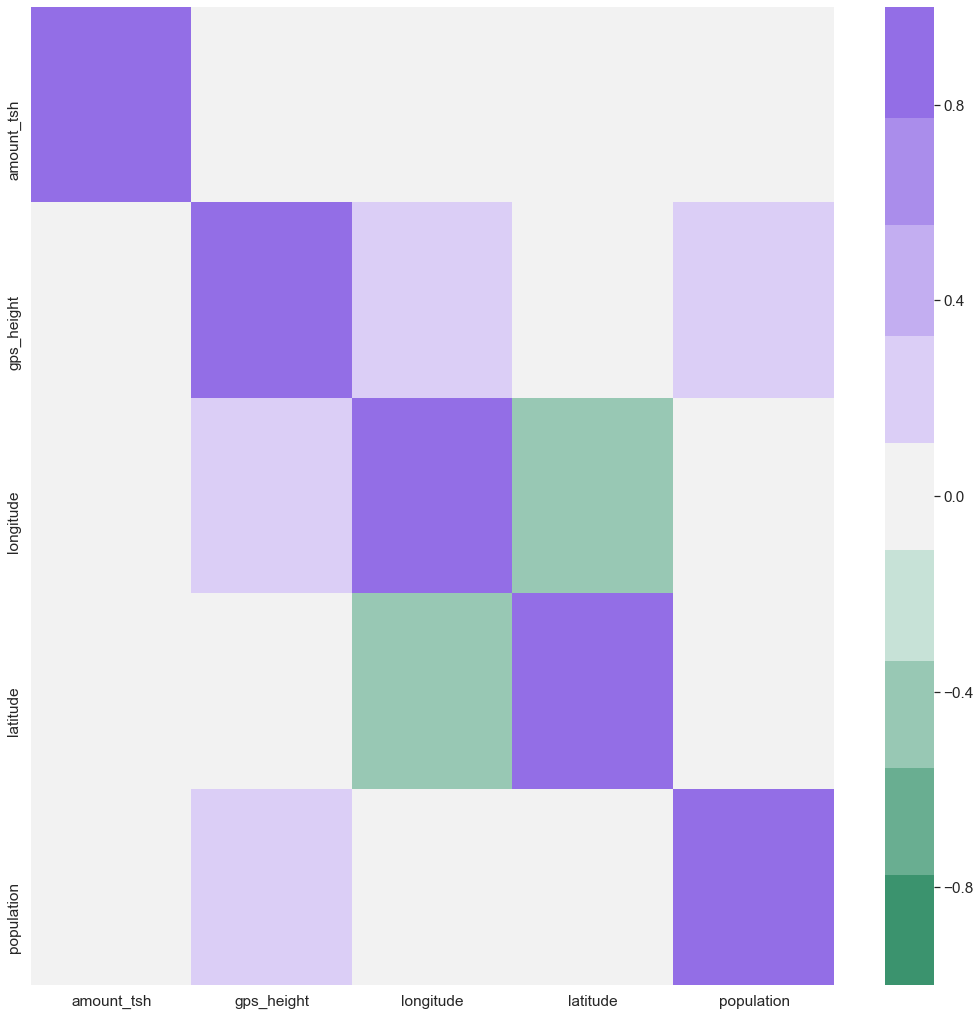

In [47]:
plt.figure(figsize=(18,18))
corr_df = train.corr()

heatmap_df=corr_df.drop(['id','num_private','region_code','district_code','construction_year']).drop(['id','num_private','region_code','district_code','construction_year'],axis=1)

sns.heatmap(heatmap_df,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9)
)

The above correlation matrix shows that the longitude and latidude features are hightly correlated. Population and gps_height are also slightly correlated. 

    Count of Categorical Features:

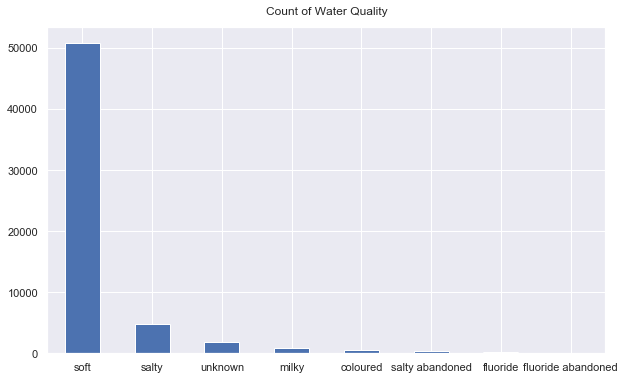

In [10]:
sns.set(font_scale=1)
train['water_quality'].value_counts().plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Count of Water Quality", y=1.02);

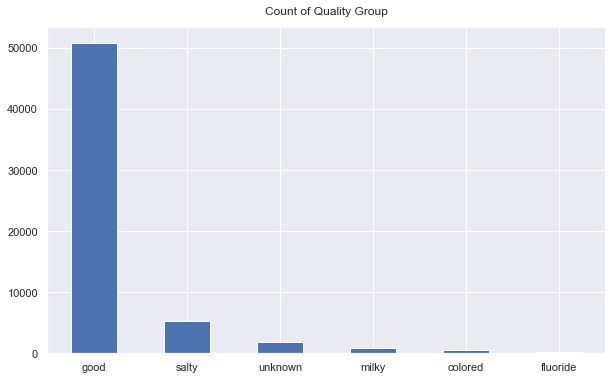

In [11]:
sns.set(font_scale=1)
train['quality_group'].value_counts().plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Count of Quality Group", y=1.02);

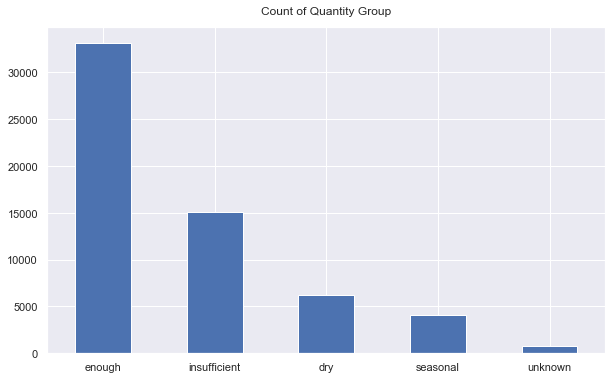

In [12]:
sns.set(font_scale=1)
train['quantity_group'].value_counts().plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Count of Quantity Group", y=1.02);

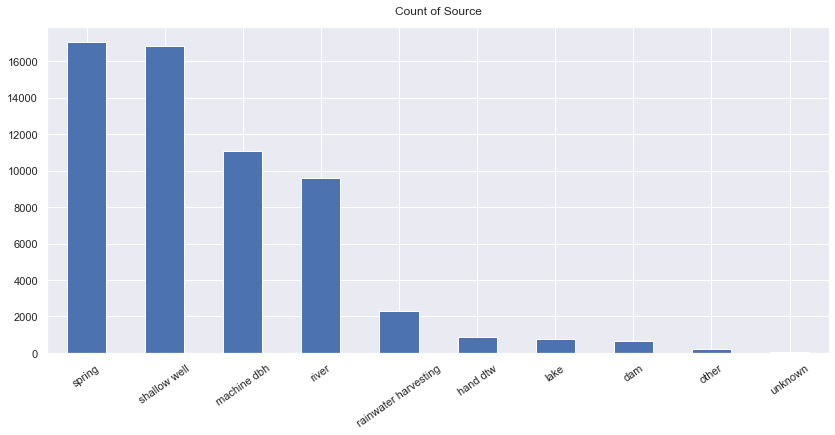

In [13]:
sns.set(font_scale=1)
train['source'].value_counts().plot(kind='bar', figsize=(14, 6), rot=35)
plt.title("Count of Source", y=1.02);

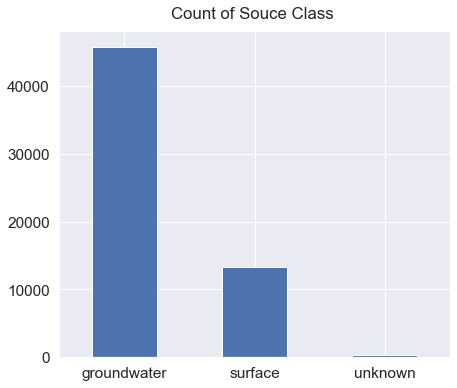

In [15]:
sns.set(font_scale=1.4)
train['source_class'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.title("Count of Souce Class ", y=1.02);

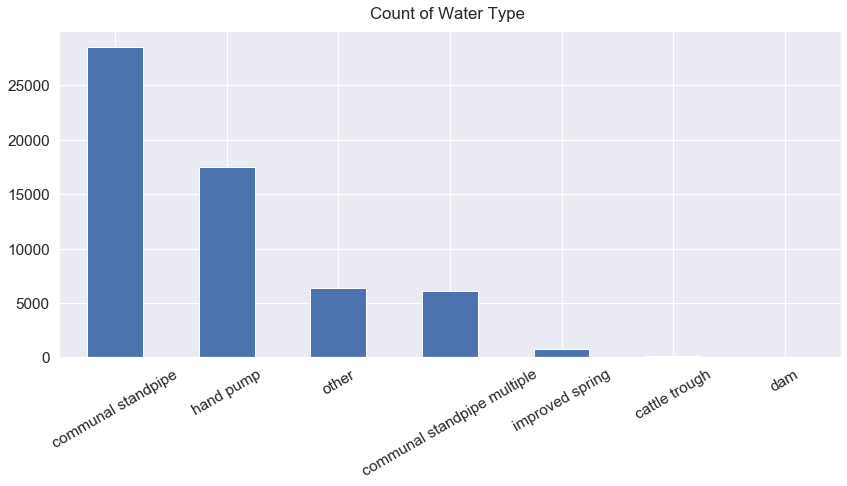

In [16]:
sns.set(font_scale=1.4)
train['waterpoint_type'].value_counts().plot(kind='bar', figsize=(14, 6), rot=30)
plt.title("Count of Water Type ", y=1.02);

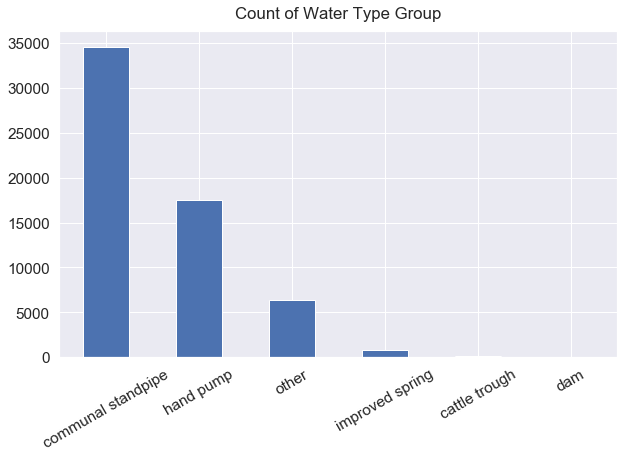

In [17]:
sns.set(font_scale=1.4)
train['waterpoint_type_group'].value_counts().plot(kind='bar', figsize=(10, 6), rot=30)
plt.title("Count of Water Type Group", y=1.02);

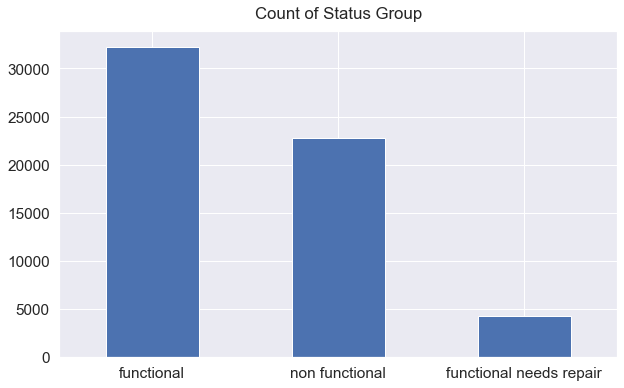

In [18]:
sns.set(font_scale=1.4)
train['status_group'].value_counts().plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Count of Status Group", y=1.02);

In [19]:
train.groupby('lga').count()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
lga,,,,,,,,,,,,,,,,,,,,,
Arusha Rural,1252,1252,1252,1204,1252,1206,1252,1252,1252,1252,...,1252,1252,1252,1252,1252,1252,1252,1252,1252,1252
Arusha Urban,63,63,63,0,63,0,63,63,63,63,...,63,63,63,63,63,63,63,63,63,63
Babati,511,511,511,509,511,509,511,511,511,511,...,511,511,511,511,511,511,511,511,511,511
Bagamoyo,997,997,997,995,997,995,997,997,997,997,...,997,997,997,997,997,997,997,997,997,997
Bahi,224,224,224,220,224,222,224,224,224,224,...,224,224,224,224,224,224,224,224,224,224
Bariadi,1177,1177,1177,1168,1177,1166,1177,1177,1177,1177,...,1177,1177,1177,1177,1177,1177,1177,1177,1177,1177
Biharamulo,403,403,403,403,403,403,403,403,403,403,...,403,403,403,403,403,403,403,403,403,403
Bukoba Rural,487,487,487,486,487,486,487,487,487,487,...,487,487,487,487,487,487,487,487,487,487
Bukoba Urban,88,88,88,0,88,0,88,88,88,88,...,88,88,88,88,88,88,88,88,88,88


## 1.2 Advanced Data Exploration



We first decided to explore the population split by region as it would be useful to know which regions contain the highest populations.

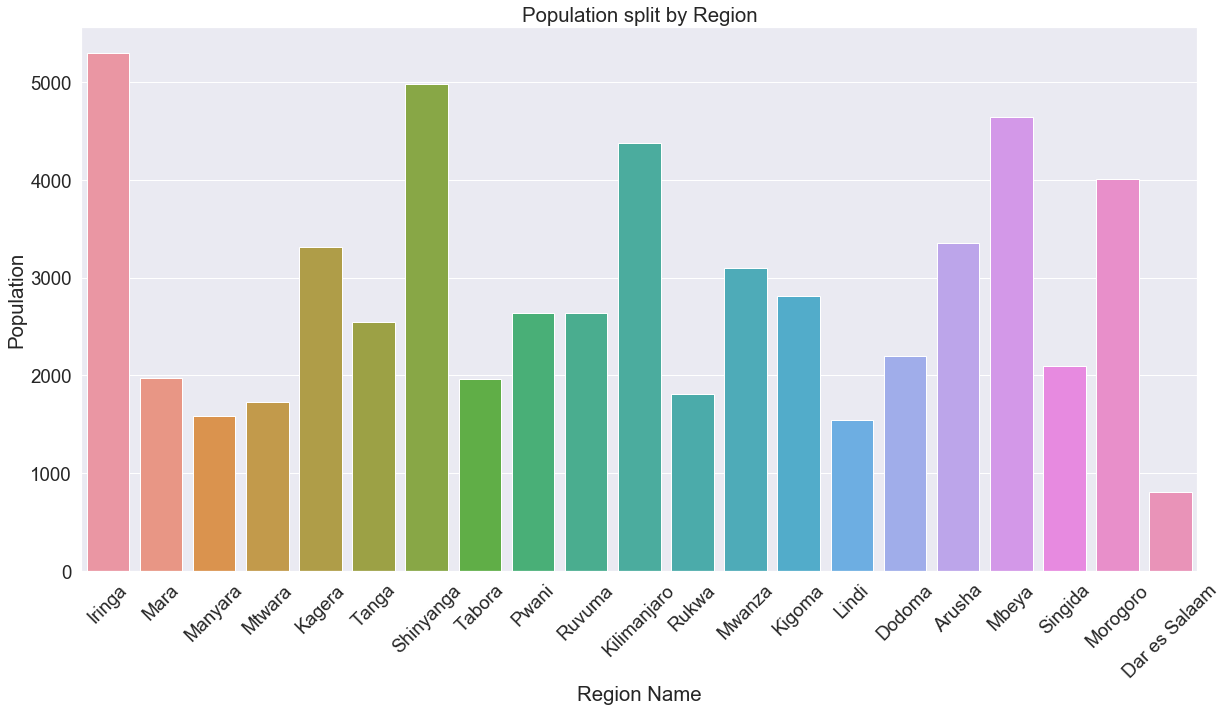

In [18]:
# A bar chart showing the population of each region
df_pop = train.dropna(subset=['region'])
df_pop = train.loc[:, ['region', 'population']]

fig = plt.gcf()
fig.set_size_inches(20, 10)

ax = sns.countplot(data=df_pop, x='region')

ax.set(xlabel='Region Name', ylabel='Population', title='Population split by Region')

sns.set(font_scale=1.7)
plt.xticks(rotation=45);

This chart gives you an idea of which regions have the highest population. Based on this it would be more interesting to see the functionality of pumps split by region.

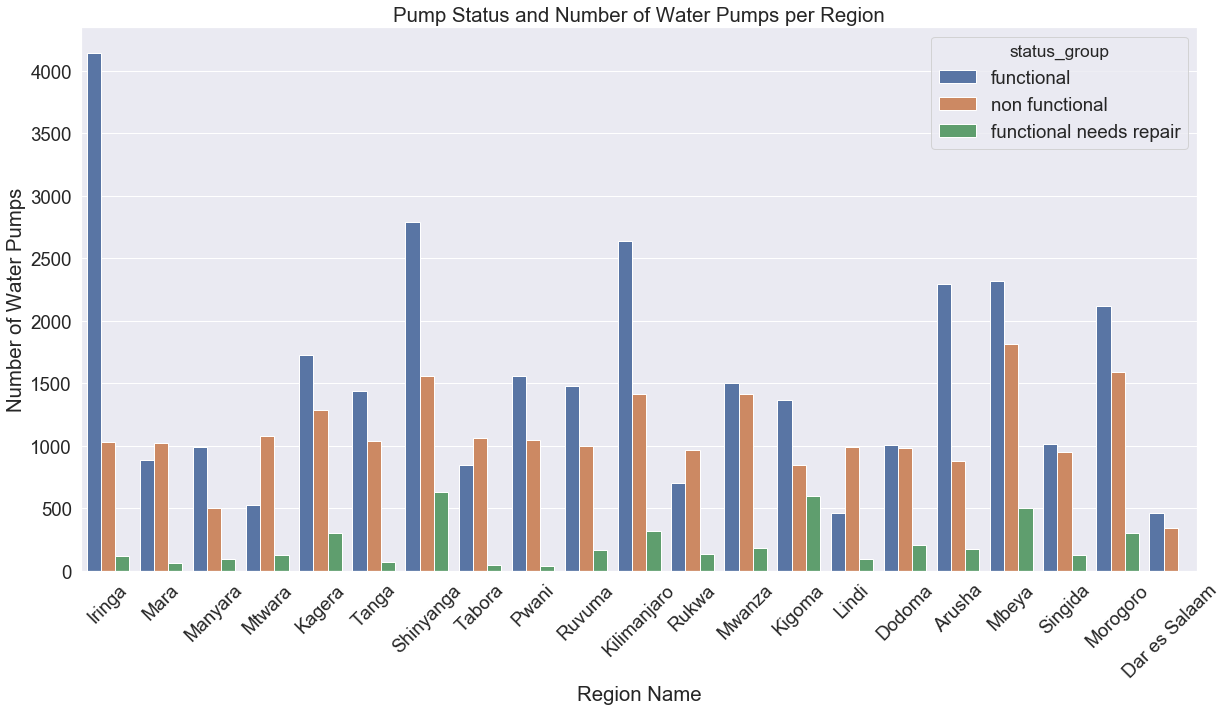

In [19]:
# A bar chart showing the number of each status group by each region
df_region = train.dropna(subset=['region'])
df_region = train.loc[:, ['region', 'status_group']]

fig = plt.gcf()
fig.set_size_inches(20, 10)

ax = sns.countplot(data=df_region, x='region', hue='status_group')

ax.set(xlabel='Region Name', ylabel='Number of Water Pumps', title='Pump Status and Number of Water Pumps per Region')

sns.set(font_scale=1.7)
plt.xticks(rotation=45);

From the chart above we can see that Dodoma - the official capital and Dar es Salaam - the commercial capital of Tanzania, have comparatively lower number of water pumps for each category of functionality compared to other regions. This could imply that these more developed regions rely on piping and have a generally better water infrastructure and therefore don't require as many water pumps.

Following this, we also wished to look at the functionality of water pumps by Waterpoint Type to see which waterpoint types were more functional than others.

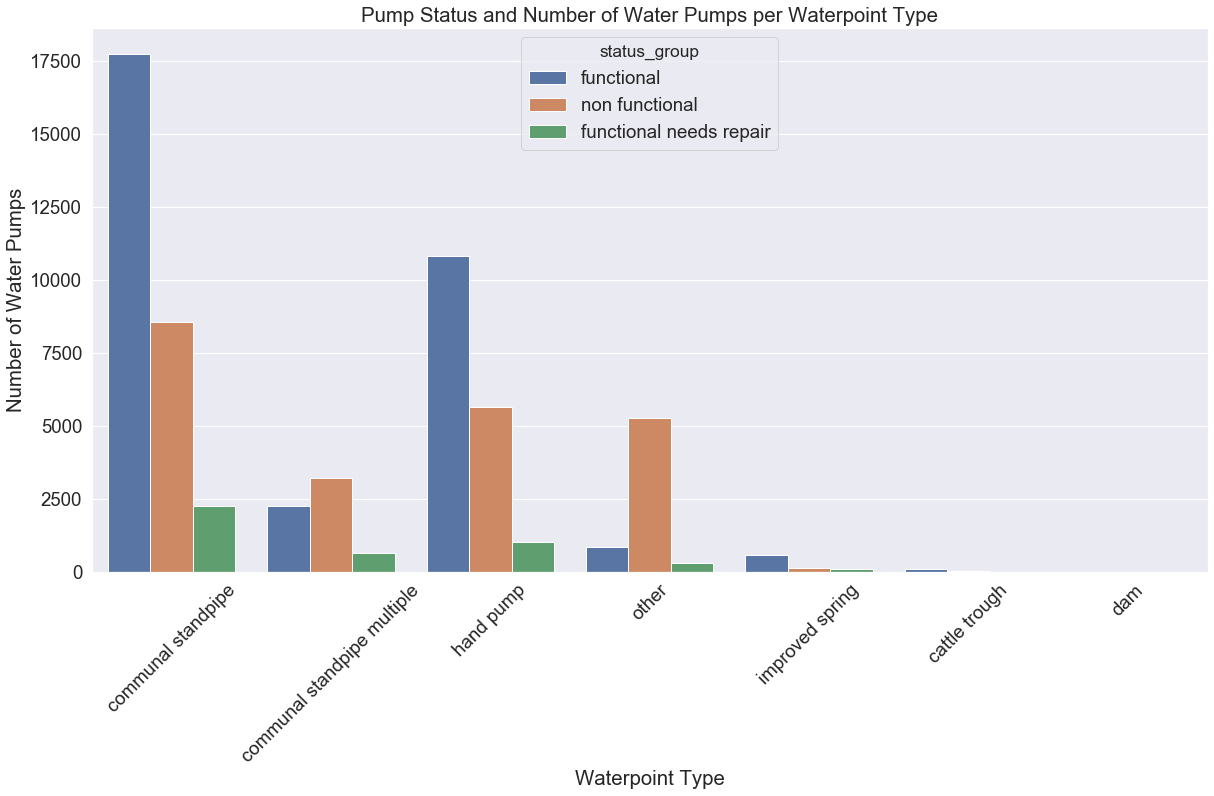

In [20]:
# A bar chart showing the number of each status group by each type of waterpoint type
df_wpt = train.dropna(subset=['waterpoint_type'])
df_wpt = train.loc[:, ['waterpoint_type', 'status_group']]

fig = plt.gcf()
fig.set_size_inches(20, 10)

ax = sns.countplot(data=df_wpt, x='waterpoint_type', hue='status_group')

ax.set(xlabel='Waterpoint Type', ylabel='Number of Water Pumps', title='Pump Status and Number of Water Pumps per Waterpoint Type')

sns.set(font_scale=1.7)
plt.xticks(rotation=45);

As we can see there is a clear majority of one type of waterpoint type which is the communal standpipe.

We also analysed the functionality by the amount_tsh(total amount of water available to a waterpoint).

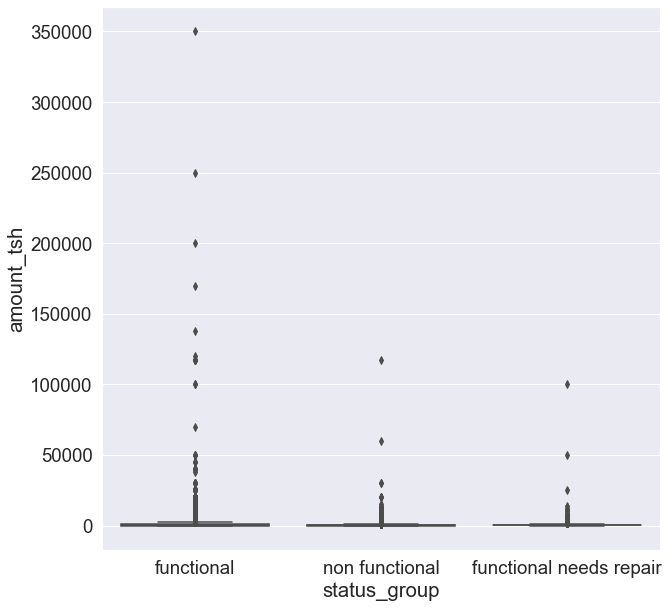

In [61]:
plt.figure(figsize = (10,10))
ax = sns.boxplot(x="status_group", y="amount_tsh", data=train.loc[(train.amount_tsh != 0)])

Plotting the data as is, gives us an idea that the distribution of the data spread across functionality is heavily skewed and uneven due to the large number of outliers.

By filtering our dataset to exclude 0 values as well as only values with an amount_tsh of over 10000, we can zoom into our dataset to get a better idea of the distribution.

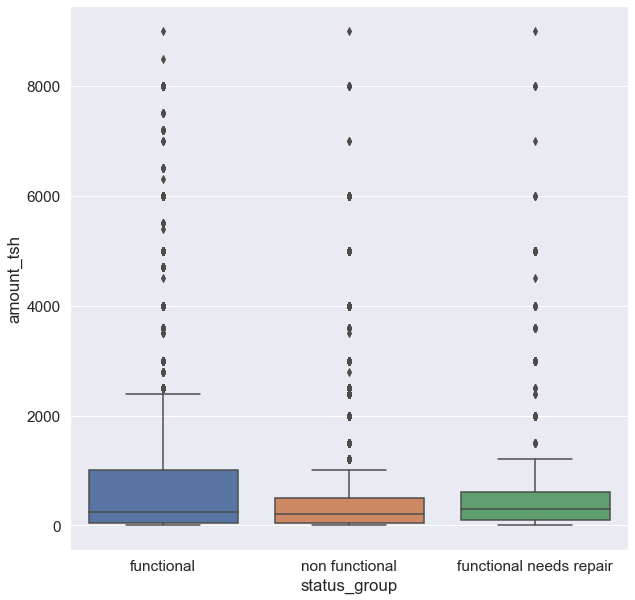

In [29]:
plt.figure(figsize = (10,10))
ax = sns.boxplot(x="status_group", y="amount_tsh", data=train.loc[(train.amount_tsh < 10000) & (train.amount_tsh != 0)])

As we can see from the plot above, the water pumps that are functional have more water and as a result also contain the majority of the outliers.

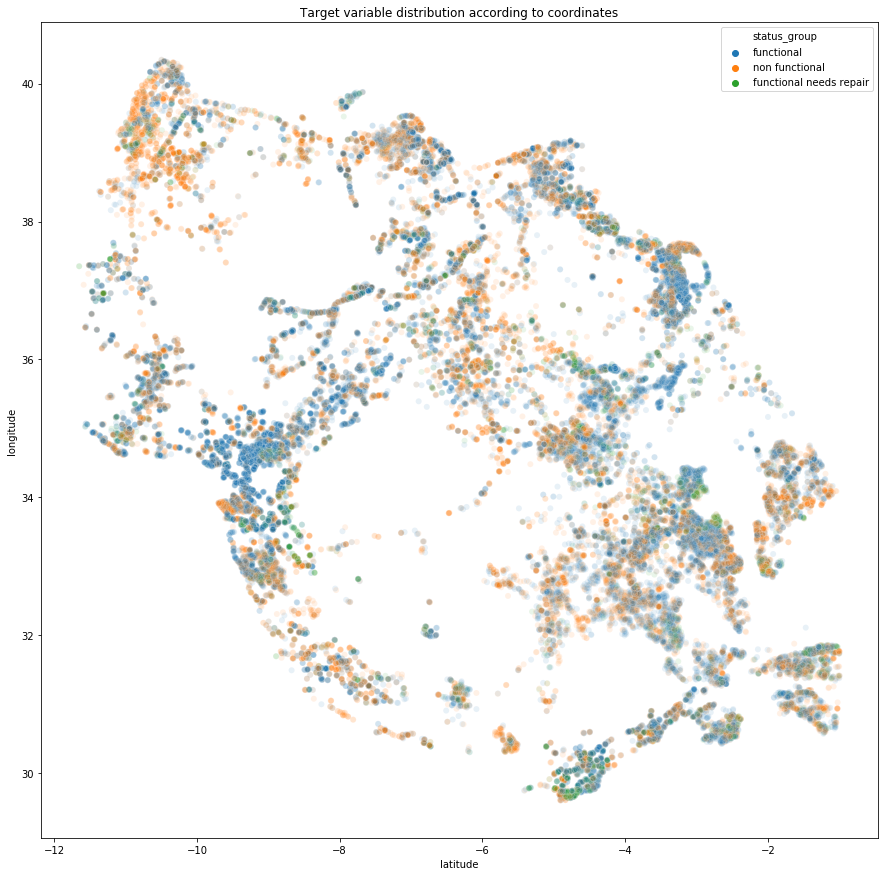

In [143]:
fig, ax = plt.subplots(figsize=(15,15))

sns.scatterplot(train[(train["latitude"].ne(0)) & (train["longitude"].ne(0))].latitude, 
                train[(train["latitude"].ne(0)) & (train["longitude"].ne(0))].longitude, hue = train.status_group, alpha = 0.1)

ax.set(title='Target variable distribution according to coordinates');

We can see that geographic coordinates may help us differentiate between classes.

### Notes:

We can see that individual variables seem to be not very effective in separating the three different classes, thus we need to include other featureas and interactions in order to capture differences between classes and being able to correctly predict them.

## 1.3 Meaningless Features

##### There are few columns that contain the same information but on different granularity level. In each case, we decided to keep columns that have more granular data and in case we needed to group them later, we would be able to do that. Columns in bold are those that we keep:
1. <strong>waterpoint_type</strong> / waterpoint_type_group
2. <strong>source</strong> / source_type / source_class
3. <strong>quantity</strong> / quantity_group
4. <strong>water_quality</strong> / quality_group
5. <strong>payment</strong> / payment_type
6. <strong>management</strong> / management_group
7. <strong>extraction_type</strong> / extraction_type_group / extraction_type_class
8. <strong>scheme_management</strong> / scheme_name
----- 
##### Besides, we decided to drop the following features because they don't contain useful information:
1. <strong>recorded_by</strong>: contains only one value, which is organization that recorded the data
2. <strong>id</strong>: surrogate key, column representing id of the observation in numerical format, doesn't contain any information.
----- 
##### We also decided to drop 4 features related to location (region, district_code, region_code, subvillage) for the following reasons:
1. combination of the features <strong>district_code, region_code</strong> gives us zip code which identifies the location, but we can get the same information in more detailed way from geograhic coordinates (<strong>longitude, latitude</strong>)
2. we have feature <strong>lga</strong> that contains similar information to <strong>region_code, region</strong> but on more granular level
3. we will use <strong>latitude</strong> and <strong>longitude</strong> for creating clusters of regions with more granularity, therefore, we can drop <strong>subvillage</strong> too
----- 
##### We are dropping <strong>public_meeting</strong> too for two reasons:
1. 86% of values are the same
2. According to research on water issue in Tanzania, public meeting at installation is not good predictor

In [3]:
columns_to_drop = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

train = train.drop(columns_to_drop, axis=1)
test = test.drop(columns_to_drop, axis=1)

## 1.4 Data Correctness

#### Installer and Funder

In [ ]:
train = DataCorrection(installer=True, funder=True).fit_transform(train)

#### Construction Year and Date Recorded

Construction date should be less than date recorded, let's validate that.

In [4]:
train['date_recorded'] = pd.to_datetime(train['date_recorded'], format='%Y-%m-%d')

In [9]:
train[train.date_recorded.dt.year < train.construction_year][['construction_year', 'date_recorded']]

,construction_year,date_recorded
8729,2008,2004-05-01
10441,2006,2004-12-01
13366,2011,2004-06-01
23373,2009,2004-03-01
27501,2009,2004-01-07
32619,2005,2004-03-01
33942,2007,2004-03-01
39559,2009,2004-03-06
48555,2008,2004-12-01


We can see that we have 8 wrong values, let's substitute them  for 0 to impute them alongside others.

In [5]:
train.loc[train.date_recorded.dt.year < train.construction_year,'construction_year'] = 0

In [11]:
train[train.date_recorded.dt.year < train.construction_year][['construction_year', 'date_recorded']]

,construction_year,date_recorded


Now everything is correct.

## 1.5 Missing Values

#### Features With Various Names For Missing Value
The dataset is quite dirty in a sense that missing values are represented in various forms:
1. simply NaN / missing cells
2. contains value "unknown", "Not known", "not known", "-", "No", "no", "0", "unknown", "none".

We tried to find those values that might represent missing value in each column and standardize them by replacing all those columns with "unknown"

In [ ]:
train = OurSimpleImputer(coords=False).fit_transform(train)

#### construction_year
This feature contains value of 0, which indicates missing value, this has been dealt with by imputing the median value for that particular `extraction_type`. This process is taken care of with the use of the `OurSimpleImputer` transformation. 

#### longitude and latitude
After checking longitude and latitude, we found that we have some of the values to be 0. Given that this is Tanzania, latitude and longitude of 0 or close to 0 are simply impossible. We decided to replace those values with mean for each LGA, which has quite detailed granularity (125 LGAs).

In [ ]:
train = OurSimpleImputer(categorical=False).fit_transform(train)

#### population
Almost 48% of observations have value "population" equal to 0 or 1. According to the description, this feature indicates the population around the particular waterpoint. It is hard to believe that the waterpoint was built for 0 or 1 person. Hence, we believe these two values indicate missing values or incorrect recording. We initially wanted to take population from other dataset and merge it with this one, however, the definition of population feature in this dataset is slightly different. Given that this is a population <strong>around</strong> a particular waterpoint, we decided to use population average of each coordinates-based cluster to impute missing values. 

(Seems like 50 is good number of K-Means clusters)

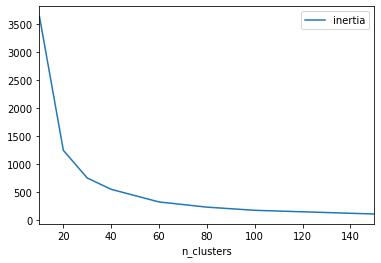

In [5]:
locations = train[['latitude','longitude']]
locations_transformed = StandardScaler().fit_transform(locations)

n_clusters = [10, 20, 30, 40, 60, 80, 100, 150]
inertia = []

for num in n_clusters:
    kmeans_model = KMeans(n_clusters=num, n_jobs=-1).fit(locations_transformed)
    wss = kmeans_model.inertia_
    inertia.append(wss)
    
pd.DataFrame({'n_clusters':n_clusters, 'inertia': inertia}).plot(x='n_clusters', y='inertia');

In [ ]:
train = Clustering().fit_transform()
train = OurAdvancedImputer().fit_transform()

# 2. Feature Engineering

Ideas:
1. Clustering based on lat/lon
2. Distance to centers (manhattan and eucledian)
3. Bucketization for population
4. Interactions
    1. scheme_management + payment
    2. basin + source
    3. source + waterpoint_type
    4. extraction_type + waterpoint_type
    5. source + extraction_type
    6. water_quality + quantity
    7. extaction_type + payment
5. Dry season from date_recorded (True/False)
6. Replace num_private to True/False
7. CountEncoder only: funder, installer, wpt_name, lga, ward
8. 1Hot / CountEncoder: basin(9), scheme_management(13), management(12), source(10), payment(7), extraction_type(18), waterpoint_type(7), water_quality(8), quantity(5)
9. Age feature: year the data was recorded - construction year
10. Construction year and amount_tsh?


In [7]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'num_private']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=True, funder=True)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance()),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False)),
    ('drop', DropColumns(features_to_drop))
])

In [8]:
train_prep = transformation_pipeline.fit_transform(original_train)

# 3. Feature Selection

## 3.1 Information Gain

In [ ]:
def information_gain(df, feature, target):
    p_target = df[target].value_counts(normalize=True)
    H_target = np.nansum(-np.log2(p_target) * p_target)
    
    p_feature_target = df.groupby(feature)[target].value_counts(normalize=True)
    p_features = df[feature].value_counts(normalize=True)
    
    H_feature = 0
    for value in df[feature].unique():
        H_value = p_features[value] * np.nansum(-np.log2(p_feature_target[value]) * p_feature_target[value])
        H_feature += H_value
    
    return H_target - H_feature 

In [ ]:
features = train_prep.columns.drop('status_group')
information_gain_features = {}
for feature in features:
    information_gain_features[feature] = information_gain(train_prep, feature, 'status_group')
sorted(information_gain_features.items(), key=lambda tup: -tup[1])    

#### Notes:
1. permit: if NA are imputed with True, information gain is 0.00083. If with False, then 0.00075. We are dropping this feature.
2. num_private: very low value of 0.00016, we decided to drop this feature
3. population_binned: very low value of 0.00226, we decided not to create this feature in next iteration and pipeline
4. installer: not corrected version of installer gives 0.189, corrected/grouped version gives 0.143
5. funder: not corrected version of installer gives 0.176, corrected/grouped version gives 0.148
6. cluster: k=50 clusters gives 0.084


## 3.2 LogisticRegression L1 selection

In [10]:
X, y = train_prep[train_prep.columns.drop("status_group")], train['status_group']

transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder(handle_unknown=0)),
    ('scaler', StandardScaler())
])

X = transformation_pipeline.fit_transform(X)

In [ ]:
X, y = train_prep[train_prep.columns.drop("status_group")], train['status_group']

transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder(handle_unknown=0)),
    ('scaler', StandardScaler())
])

X = transformation_pipeline.fit_transform(X)

logistic = LogisticRegressionCV(Cs=[3, 10, 30, 100], penalty="l1", 
                                multi_class='multinomial',solver='saga', cv=3, n_jobs=-1).fit(X, y);
model = SelectFromModel(logistic, prefit=True);

X_new = model.transform(X);

selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=train_prep.index,
                                 columns=train_prep.drop('status_group', axis=1).columns)

dropped_columns = selected_features.columns[selected_features.var() == 0]
dropped_columns

#### Notes:
Lasso selection didn't remove any features, so we can continue with modeling and hyperparameter tuning


# 4. Modeling and Evaluation

## 4.1.1 Random Forest without PCA

In [ ]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'num_private', 'permit', 'water_quality']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=False, funder=False)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance(strategy='eucledian')),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False, dry_season=False)),
    ('drop', DropColumns(features_to_drop)),
    ('encoder', CountEncoder(handle_unknown=0))
])

class_to_num = {'functional': 2, 'non functional': 0, 'functional needs repair': 1}
num_to_class = {0:'non functional', 1: 'functional needs repair', 2: 'functional'} 

X = original_train.drop('status_group', axis=1)
y = original_train.status_group.replace(class_to_num)

X_prep = transformation_pipeline.fit_transform(X)

rf = RandomForestClassifier(n_jobs=-1)

# setting grid
param_grid_forest = {
    'max_depth': [10, 25, 50, None],
    'n_estimators': [50, 100]
}

grid_search_forest = GridSearchCV(rf, cv=5, param_grid=param_grid_forest,n_jobs=-1).fit(X_prep, y)

### evaluation

In [ ]:
print('Train performance on Random Forest w/o PCA: ', grid_search_forest.best_estimator_.score(X_prep, y))

In [ ]:
params = ['rank_test_score','mean_test_score', 'param_max_depth', 'param_n_estimators']
pd.DataFrame(grid_search_forest.cv_results_)[params].sort_values('rank_test_score')

### feature importance

In [ ]:
sorted([*zip(X_prep.columns, grid_search_forest.best_estimator_.feature_importances_)], key=lambda tup: -tup[1])

### error analysis

* Rows: actual class
* Columns: predicted class

In [ ]:
y_pred_cv = cross_val_predict(grid_search_forest.best_estimator_, X_prep, y, cv=5)
conf_mx = confusion_matrix(y, y_pred_cv)
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#### Notes:
Our model is overfitting based on the difference between train performance (0.99) and cross-validation performance (0.81). 
Feature importance shows that wee need to drop two features "dry_season" and "water_quality". After removing those two features and reducing max_depth to 100, our generalization didn't improve. We figured out also that using "Eucledian" distance gives slightly better performance than "Manhattan" in transformer "Distance()". 

Based on error analysis, we can see that Random Forest is doing a lot of mistakes in predicting class 1 which is "non functional needs repair". This is understable given the heavy imbalance of this class (around 7% of classes). 

The best parameters based on CV: 
1. n_estimators = 100
2. max_depth = 25

### submission creation

In [ ]:
test_prep = transformation_pipeline.transform(test)
y_pred = grid_search_forest.best_estimator_.predict(test_prep)

test_id = pd.read_csv('data/test.csv').id
submission = pd.DataFrame({"id": test_id, "status_group": y_pred})
submission = submission.replace({'status_group': num_to_class})
submission.to_csv('submission_rf.csv', index=False)

## 4.1.2 Random Forest with PCA

In [ ]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'num_private', 'permit', 'water_quality']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=False, funder=False)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance(strategy='eucledian')),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False, dry_season=False)),
    ('drop', DropColumns(features_to_drop)),
    ('encoder', CountEncoder(handle_unknown=0)),
    ('scaler', StandardScaler()),
    ('boxcos', PowerTransformer()),
    ('PCA', PCA())
])

class_to_num = {'functional': 2, 'non functional': 0, 'functional needs repair': 1}
num_to_class = {0:'non functional', 1: 'functional needs repair', 2: 'functional'} 

X = original_train.drop('status_group', axis=1)
y = original_train.status_group.replace(class_to_num)

X_prep = transformation_pipeline.fit_transform(X)

rf_pca = RandomForestClassifier(n_jobs=-1)

# setting grid
param_grid_forest = {
    'max_depth': [10, 25, 50, None],
    'n_estimators': [50, 100]
}

grid_search_forest_pca = GridSearchCV(rf_pca, cv=5, param_grid=param_grid_forest,n_jobs=-1).fit(X_prep, y)

### evaluation

In [ ]:
print('Train performance on Random Forest w/ PCA: ', grid_search_forest_pca.best_estimator_.score(X_prep, y))

In [ ]:
params = ['rank_test_score','mean_test_score', 'param_max_depth', 'param_n_estimators']
pd.DataFrame(grid_search_forest_pca.cv_results_)[params].sort_values('rank_test_score')

### error analysis

* Rows: actual class
* Columns: predicted class

In [ ]:
y_pred_cv = cross_val_predict(grid_search_forest_pca.best_estimator_, X_prep, y, cv=5)
conf_mx = confusion_matrix(y, y_pred_cv)
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#### Notes:
Similar issues with Random Forest run without PCA, except for the performance on cross-validation got worse (from 0.81 to 0.77).  

## 4.2 XGBoost

In [ ]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'num_private', 'permit', 'water_quality']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=False, funder=False)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance(strategy='eucledian')),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False, dry_season=False)),
    ('drop', DropColumns(features_to_drop)),
    ('encoder', CountEncoder(handle_unknown=0))
])

class_to_num = {'functional': 2, 'non functional': 0, 'functional needs repair': 1}
num_to_class = {0:'non functional', 1: 'functional needs repair', 2: 'functional'} 

X = original_train.drop('status_group', axis=1)
y = original_train.status_group.replace(class_to_num)

X_prep = transformation_pipeline.fit_transform(X)


xgb_model = XGBClassifier(n_jobs=-1)

# setting grid
param_grid_xgb = {
    'max_depth': [20],
    'learning_rate': [0.03, 0.1, 0.3]
}

grid_search_xgb = GridSearchCV(xgb_model, cv=5, param_grid=param_grid_xgb, n_jobs=-1).fit(X_prep, y)

### evaluation

In [ ]:
print('Train performance on XGB: ', grid_search_xgb.best_estimator_.score(X_prep, y))

In [ ]:
params = ['rank_test_score','mean_test_score', 'param_max_depth', 'param_learning_rate']
pd.DataFrame(grid_search_xgb.cv_results_)[params].sort_values('rank_test_score')

### error analysis

In [ ]:
y_pred_cv = cross_val_predict(grid_search_xgb.best_estimator_, X_prep, y, cv=5)
conf_mx = confusion_matrix(y, y_pred_cv)
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#### Notes:
The best parameters based on CV: 
1. learning_rate = 0.1
2. max_depth = 20

### submission creation

In [ ]:
test_prep = transformation_pipeline.transform(test)
y_pred = grid_search_xgb.best_estimator_.predict(test_prep)

test_id = pd.read_csv('data/test.csv').id
submission = pd.DataFrame({"id": test_id, "status_group": y_pred})
submission = submission.replace({'status_group': num_to_class})
submission.to_csv('submission_gbm.csv', index=False)

### Notes:
Here we can note that the performance of the XGBoost classifier was marginally worse than that of the random forest classifier.

## 4.3 LDA Trial

In [ ]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'num_private', 'permit', 'water_quality']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=False, funder=False)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance(strategy='eucledian')),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False, dry_season=False)),
    ('drop', DropColumns(features_to_drop)),
    ('encoder', CountEncoder(handle_unknown=0)),
    ('scaler', StandardScaler()),
    ('boxcos', PowerTransformer())
])

class_to_num = {'functional': 2, 'non functional': 0, 'functional needs repair': 1}
num_to_class = {0:'non functional', 1: 'functional needs repair', 2: 'functional'} 

X = original_train.drop('status_group', axis=1)
y = original_train.status_group.replace(class_to_num)

X_prep = transformation_pipeline.fit_transform(X)

lda = LDA()

# setting grid
param_grid_lda = {
    'n_components': [2, 10]
}

grid_search_forest_LDA = GridSearchCV(lda, cv=5, param_grid=param_grid_lda,n_jobs=-1).fit(X_prep, y)

### evaluation

In [ ]:
print('Train performance on LDA: ', grid_search_forest_LDA.best_estimator_.score(X_prep, y))

In [ ]:
params = ['rank_test_score','mean_test_score']
pd.DataFrame(grid_search_forest_LDA.cv_results_)[params].sort_values('rank_test_score')

### Notes:

The performance of the LDA classifier is significantly worse than those of the other classifiers used, and as such will not be further explored.


## 4.4 LightGBM

In [6]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'num_private', 'permit', 'water_quality']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=False, funder=False)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance(strategy='eucledian')),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False, dry_season=False)),
    ('drop', DropColumns(features_to_drop)),
    ('encoder', CountEncoder(handle_unknown=0))
])

class_to_num = {'functional': 2, 'non functional': 0, 'functional needs repair': 1}
num_to_class = {0:'non functional', 1: 'functional needs repair', 2: 'functional'} 

X = original_train.drop('status_group', axis=1)
y = original_train.status_group.replace(class_to_num)

X_prep = transformation_pipeline.fit_transform(X)

lgb = LGBMClassifier(objective='multiclass',num_class=3)

param_grid_lgb = {
    'num_leaves': [64,128],
    'learning_rate': [0.3, 1],
    'max_depth': [16],
    'min_data_in_leaf': [200, 500]
}

grid_search_lgb = GridSearchCV(lgb, cv=5, param_grid=param_grid_lgb,n_jobs=-1).fit(X_prep, y)

### evaluation

In [7]:
print('Train performance on LightGBM: ', grid_search_lgb.best_estimator_.score(X_prep, y))

Train performance on LightGBM:  0.8932154882154882


In [10]:
params = ['rank_test_score','mean_test_score', 'param_num_leaves', 'param_learning_rate','param_min_data_in_leaf']
pd.DataFrame(grid_search_lgb.cv_results_)[params].sort_values('rank_test_score')

,rank_test_score,mean_test_score,param_num_leaves,param_learning_rate,param_min_data_in_leaf
1,1,0.803485,128,0.3,200
0,2,0.803030,64,0.3,200
3,3,0.800219,128,0.3,500
2,4,0.799966,64,0.3,500
7,5,0.796919,128,1,500
6,6,0.796465,64,1,500
4,7,0.795000,64,1,200
5,8,0.792003,128,1,200


### error analysis

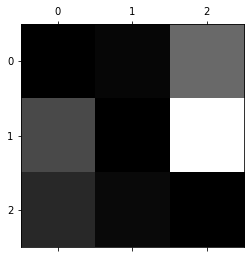

In [11]:
y_pred_cv = cross_val_predict(grid_search_lgb.best_estimator_, X_prep, y, cv=5)
conf_mx = confusion_matrix(y, y_pred_cv)
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#### Notes:
Best parameters based on CV:
1. num_leaves: 128
2. learning_rate: 0.3
3. min_data_in_leaf: 200
4. max_depth: 16

### submission creation

In [12]:
test_prep = transformation_pipeline.transform(test)
y_pred = grid_search_lgb.best_estimator_.predict(test_prep)

test_id = pd.read_csv('data/test.csv').id
submission = pd.DataFrame({"id": test_id, "status_group": y_pred})
submission = submission.replace({'status_group': num_to_class})
submission.to_csv('submission_lgb.csv', index=False)

### Notes:

LightGBM showed significant improvement in performance, in terms of speed, when running for this model. The result of this classifier was marginally worse than that of the original classifier. 

## 4.5 Voting Classifier

Having ran the individual classifiers, combining the results obtained from them, may yield in a better overall model. As such, a voting classifier will be designed in which the best three individual models will be incorporated.

In [7]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'num_private', 'permit', 'water_quality']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=False, funder=False)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance(strategy='eucledian')),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False, dry_season=False)),
    ('drop', DropColumns(features_to_drop)),
    ('encoder', CountEncoder(handle_unknown=0))
])

class_to_num = {'functional': 2, 'non functional': 0, 'functional needs repair': 1}
num_to_class = {0:'non functional', 1: 'functional needs repair', 2: 'functional'} 

X = original_train.drop('status_group', axis=1)
y = original_train.status_group.replace(class_to_num)

X_prep = transformation_pipeline.fit_transform(X)

lgb_clf = LGBMClassifier(objective='multiclass',num_class=3, min_data_in_leaf=200, num_leaves=128, learning_rate=0.3, max_depth=16)
xgb_clf = XGBClassifier(n_jobs=-1, max_depth=20, learning_rate=0.1)
rf_clf = RandomForestClassifier(max_depth=25, n_estimators=100, n_jobs=-1)

voting_clf = VotingClassifier(estimators=[
    ('rf', rf_clf), 
    ('lgb', lgb_clf),
    ('xgb', xgb_clf)], voting='soft')

voting_clf.fit(X_prep, y)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=25,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=100,
                                                     n_jobs=-1, oob_score=Fals

In [8]:
test_prep = transformation_pipeline.transform(test)
y_pred = voting_clf.predict(test_prep)

test_id = pd.read_csv('data/test.csv').id
submission = pd.DataFrame({"id": test_id, "status_group": y_pred})
submission = submission.replace({'status_group': num_to_class})
submission.to_csv('submission_voting.csv', index=False)

## Notes:

This resulted in the best score through the submission on DrivenData, and as such is the final submission. The better result was recieved with the soft voting.

The final score obtained was 0.8171 under the username kate901chunosova. 

## 5. Final Remarks

There's a heavy class imbalance in the dataset, which results in one of the classes being predicted worse than the other two (functional, non functional). Potentially, this could be improved by applying oversampling technique like SMOTE in order to balance `functional needs repair` class to improve the results of the model. 

Another thing that could be done, is trying to engineer other useful features or build a separate model just to learn specifically `functional needs repair` class.